# Micrograd

Micrograd is a tiny model that performs backpropagation for educational purposes. It uses scalar values and operations, but the concepts are the same as they would be for tensors.

In [ ]:
import math
import random

## Derivatives

There is a basic introduction to derivatives that I have skipped since it is very basic.

## Micrograd Classes

In [ ]:
class Value:

  def __init__(self,data):
    self.data = data

  def __repr__(self):
    return f'Value(data={self.data})'

In [ ]:
a = Value(2.0)
a

Value(data=2.0)

In [ ]:
b = Value(-3.0)
a + b

TypeError: ignored

We need an addition method to allow this.

In [ ]:
class Value:

  def __init__(self,data):
    self.data = data

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a + b)
print(a*b+c)
print(a.__mul__(b).__add__(c))

Value(data=-1.0)
Value(data=4.0)
Value(data=4.0)


Now we want the values to learn about the calculation tree, and track their children.

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b+c

print(d._prev)
print(d._op)

{Value(data=10.0), Value(data=-6.0)}
+


Now, we will make this look nicer. I copied this code from the repo, so it does not exactly match the video.

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a*b
d.label='d'
e = d+c
e.label='e'

print(d._prev)
print(d._op)

{Value(data=-3.0), Value(data=2.0)}
*


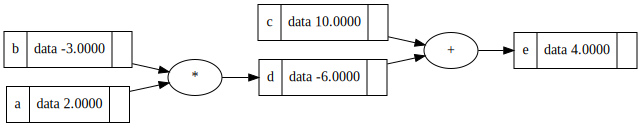

In [ ]:
draw_dot(e)

Now we can add in the gradients:

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad=0.0
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

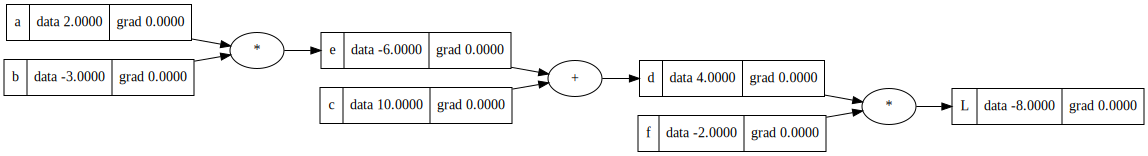

In [ ]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label='e'
d = e+c
d.label='d'
f = Value(-2.0,label='f')
L = d*f; L.label='L'

draw_dot(L)

## Manually computing gradients

In [ ]:
def lol():

  h = .0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label='e'
  d = e+c
  d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data


  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label='e'
  d = e+c
  d.label='d'
  f = Value(-2.0,label='f')

  L = d*f; L.label='L'

  L2 = L.data

  print((L2 - L1)/h)




lol()

6.000000000021544


In [ ]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0


The most important step here is understanding $\frac{dL}{dc}$.

Recall that $\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}$.

Then we have $\frac{dL}{dc}$ = -2.0 * 1.0 = -2.0

In [ ]:
c.grad = -2.0
e.grad = -2.0


Similarly, we can use chain rule again to reach $\frac{dL}{da} = \frac{dL}{dd}*\frac{dd}{de}*\frac{de}{da}$.

In [ ]:
a.grad = 6.0
b.grad = -4.0

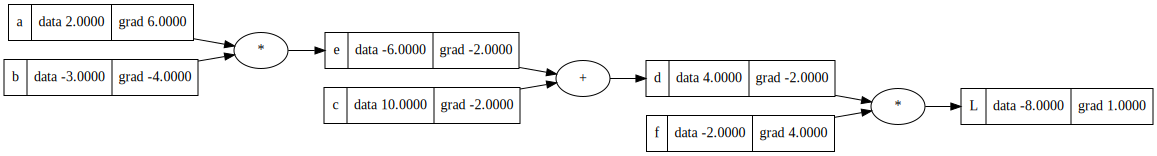

In [ ]:
draw_dot(L)

Let's test this, by increasing the inputs by a small fraction of the gradient, which should increase L.

In [ ]:
step = .01

a.data += step
b.data += step
c.data += step
f.data += step

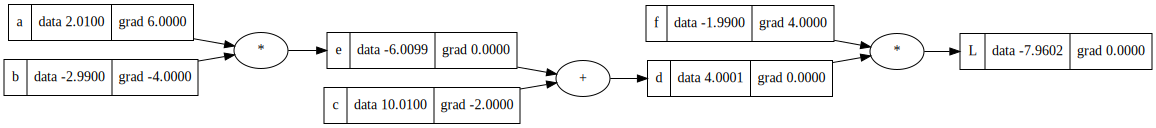

In [ ]:
e = a*b
e.label='e'
d = e+c
d.label='d'
L = d*f; L.label='L'
draw_dot(L)

## Applying this to a neuron

Typically, a neuron in a neural network includes an activation function, which makes this math slightly more complicated. An easy example is tanh.

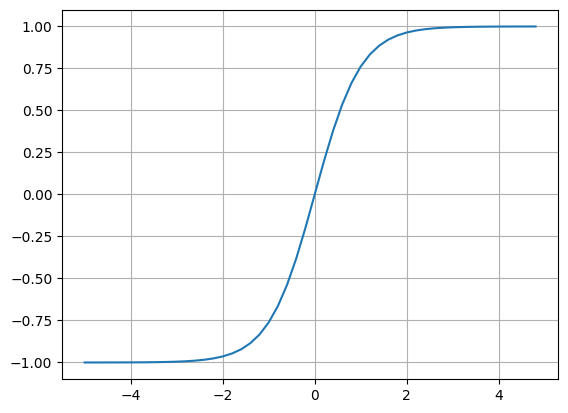

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

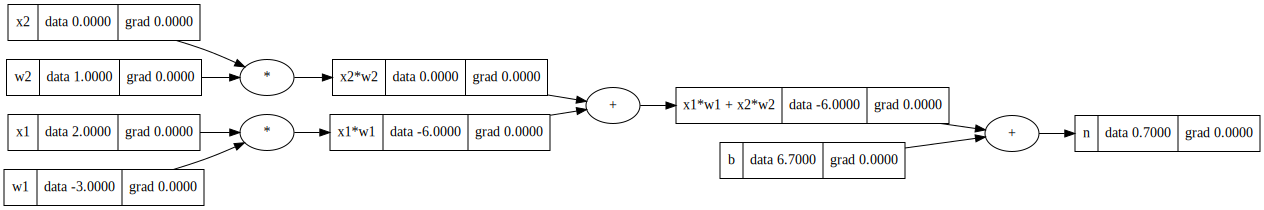

In [ ]:
draw_dot(n)

You don't need to work out all the pieces if you know the overall derivative. For example, with tanh we can implement directly rather than using division and exponents.

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad=0.0
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    return out

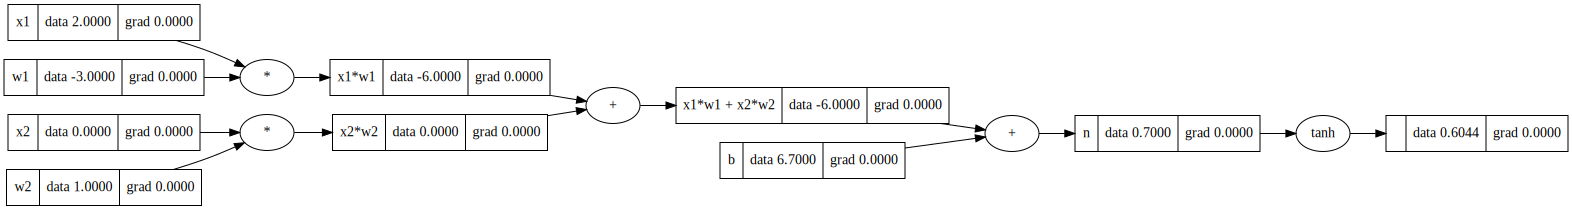

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh()

draw_dot(o)

Now we know that the derivative of $tanh(x)$ is just $1 - tanh^2(x)$

In [ ]:
o.grad = 1.0
n.grad = 1 - o.data**2

x1w1.grad = n.grad
x2w2.grad = n.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

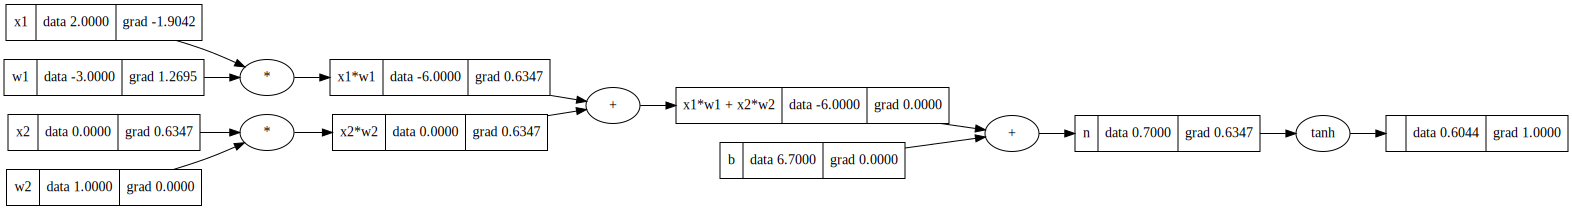

In [ ]:
draw_dot(o)

## Creating *backward*

Now let's stop doing these calculations by hand:

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad=0.0
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = out.grad
      other.grad = out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')


    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

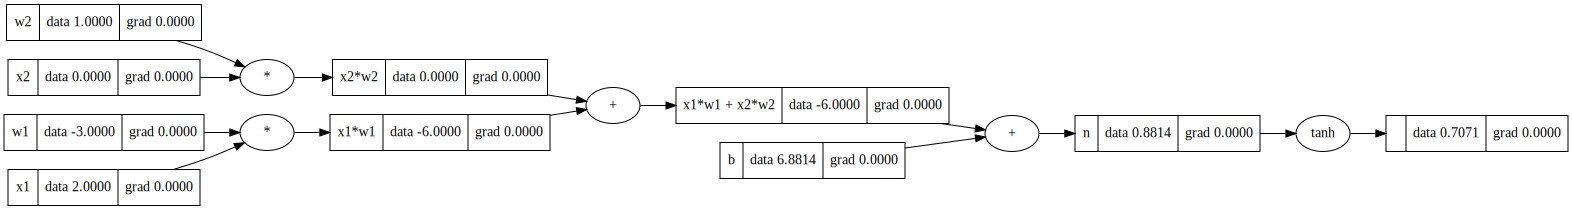

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh()

draw_dot(o)

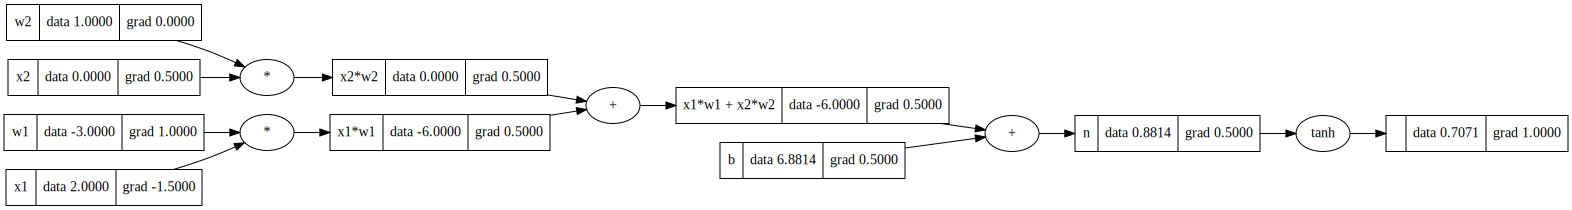

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

Now we want to build a topological sort so that we can call backward automatically in the correct order.

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad=0.0
    self._backward = lambda: None
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')


    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


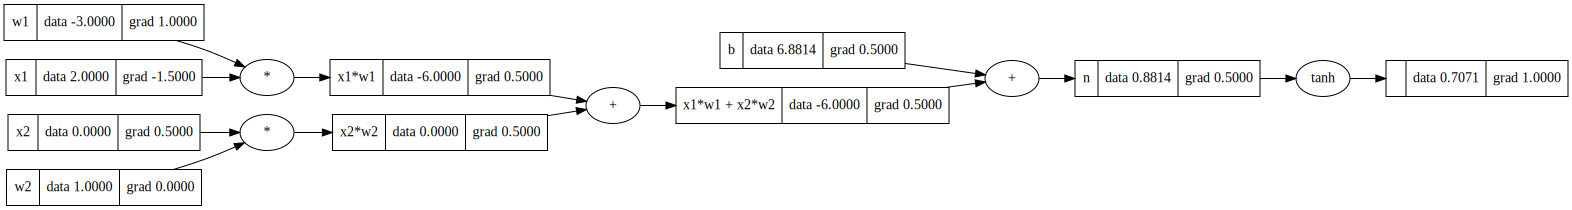

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh()

o.backward()

draw_dot(o)

## Adding in more operations

In [ ]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad=0.0
    self._backward = lambda: None
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

  def __truediv__(self, other):
    return self * other**-1

  def __rmul__(self, other):
    return self * other

  def __radd__(self,other):
    return self + other

  def __neg__(self): # -self
      return self * -1

  def __radd__(self, other): # other + self
      return self + other

  def __sub__(self, other): # self - other
      return self + (-other)

  def __rsub__(self, other): # other - self
      return other + (-self)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')


    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')


    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


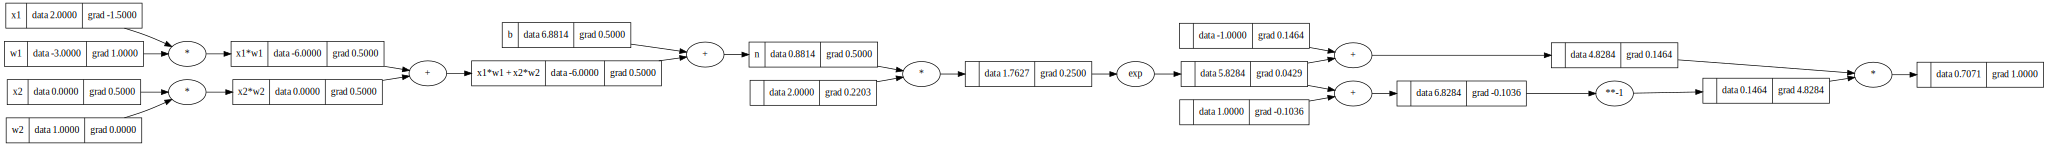

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.backward()

draw_dot(o)

# Doing the same in Pytorch

In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor(6.8813735870195432).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print(x2.grad.item())
print(w2.grad.item())
print(x1.grad.item())
print(w1.grad.item())

0.7071066904050358
---
0.5000001283844369
0.0
-1.5000003851533106
1.0000002567688737


## Building a Neural Net

In [ ]:
class Neuron():

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'Tanh' if self.nonlin else 'Linear'}Neuron({len(self.w)})"


class Layer():

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP():

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [ ]:
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.9039693647141569),
 Value(data=-0.6940467452983697),
 Value(data=-0.9995543566986064)]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.16788084757830948)

In [ ]:
xs= [[2.0, 3.0, -1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0]

In [ ]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.16788084757830948),
 Value(data=-0.4243500392445648),
 Value(data=0.04357443283583382),
 Value(data=0.01972396915608394)]

In [ ]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.0737838546604612)

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

-1.7692397711344072

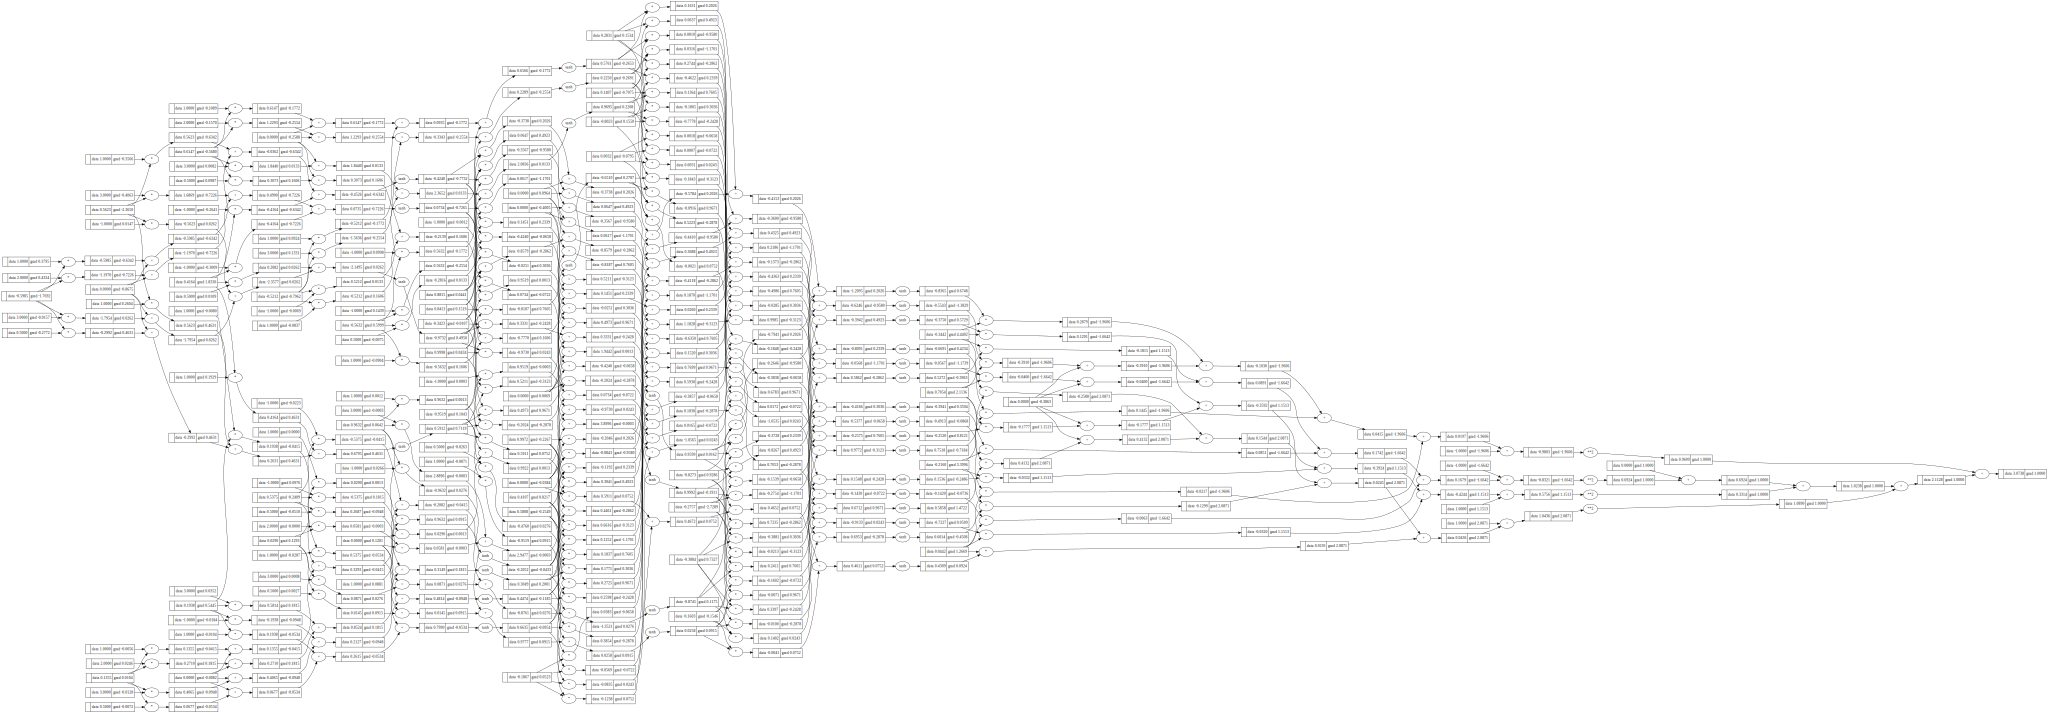

In [ ]:
draw_dot(loss)

Now we want to update the parameters

In [ ]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])


In [ ]:
loss.backward()
for p in n.parameters():
  p.data += 0.01 * -p.grad

In [ ]:
loss

Value(data=3.0737838546604612)

In [ ]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.005563149744399)

Putting it all together:

In [ ]:
for k in range(100):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters(): #don't forget to set the gradients back to zero
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += 0.01 * -p.grad

  if k%10 == 0:
    print(loss)

Value(data=2.005563149744399)
Value(data=0.27492686366714264)
Value(data=0.03852112472960508)
Value(data=0.007974998703856546)
Value(data=0.0021447145465559843)
Value(data=0.0007066903787914367)
Value(data=0.00028040619171968247)
Value(data=0.0001274258165691688)
Value(data=6.263433075900064e-05)
Value(data=3.204104122182417e-05)
